In [ ]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tensorflow.keras.utils import to_categorical

In [ ]:
#The data is derived from the preprocessing files in /app_emulation by Philipp. He segmented the dataset to emphasize combustion-related features for Richard and me.
df = pd.read_csv("app_emulation/files/23_22_21-eea_europa_eu-CarsCO2_combustion.csv")
df.head()

C:\Users\T\AppData\Local\Temp\ipykernel_2568\2245148285.py:1: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("app_emulation/files/23_22_21-eea_europa_eu-CarsCO2_combustion.csv")


,ID,member_state,manufacturer_name_eu,vehicle_type,commercial_name,category_of_vehicle,fuel_type,fuel_mode,innovative_technologies,mass_vehicle,weltp_test_mass,engine_capacity,engine_power,erwltp,year,electric_range,electric_energy_consumption,fuel_consumption,specific_co2_emissions
0,56002959,GR,HYUNDAI,OS,"KONA,KAUAI",M1,diesel,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0
1,56002960,GR,HYUNDAI,OS,"KONA,KAUAI",M1,diesel,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0
2,56002961,GR,HYUNDAI,OS,"KONA,KAUAI",M1,diesel,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0
3,56002962,GR,HYUNDAI,OS,"KONA,KAUAI",M1,diesel,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0
4,56002963,GR,HYUNDAI,OS,"KONA,KAUAI",M1,diesel,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0


In [ ]:
#thanks to Richard for sharing his extensive NaN column analysis, I could loop over them with a for loop and fillna() on them.
numeric_columns_with_nans = ['mass_vehicle', 'engine_capacity',
                             'engine_power', 'fuel_consumption']

for column in numeric_columns_with_nans:
    df[column].fillna(df[column].mean(), inplace=True)

print(df[numeric_columns_with_nans].isna().sum())
#as seen below, we now how all the NaNs in the columns filled.

C:\Users\T\AppData\Local\Temp\ipykernel_2568\201083025.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


mass_vehicle        0
engine_capacity     0
engine_power        0
fuel_consumption    0
dtype: int64


In [ ]:
df.head()
#We removed categorical variables that could introduce bias, such as vehicle name, manufacturer, and the country of the manufacturer, to maintain an unbiased approach in our predictions.
#I also dropped the electric columns that were still left after Philipp's great work on the preprocessing
#ID, which by my mistake was still a part in early model runthroughs, is now also dropped.
#Following a coaching session with Romain, I was also advised to exclude variables directly associated with environmental impact, such as CO2 emissions, and focus solely on the vehicle characteristics themselves. As such, specific_co2_emissions, erwltp, were dropped
#We also made a decision as a team between keeping either mass_vehicle and weltp_test_mass out of redundancy, and dropped the latter one.
df = df.drop(['member_state', 'manufacturer_name_eu', 'commercial_name', 'innovative_technologies', 'year', 'electric_range', 'electric_energy_consumption', 'ID', 'weltp_test_mass', 'specific_co2_emissions', 'erwltp'], axis=1)


C:\Users\T\AppData\Local\Temp\ipykernel_22496\2611653623.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fuel Type', y='Counts', data=fuel_type_counts, palette='viridis')


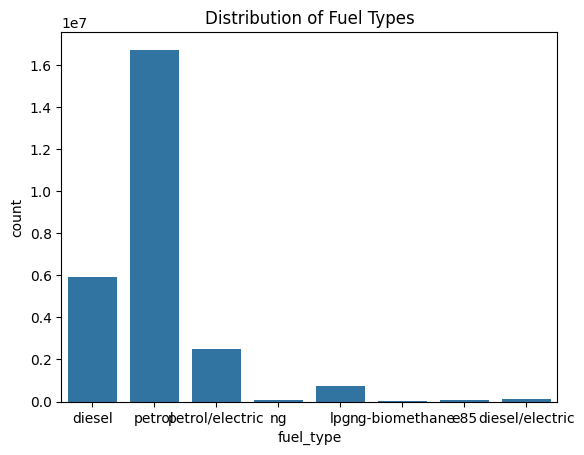

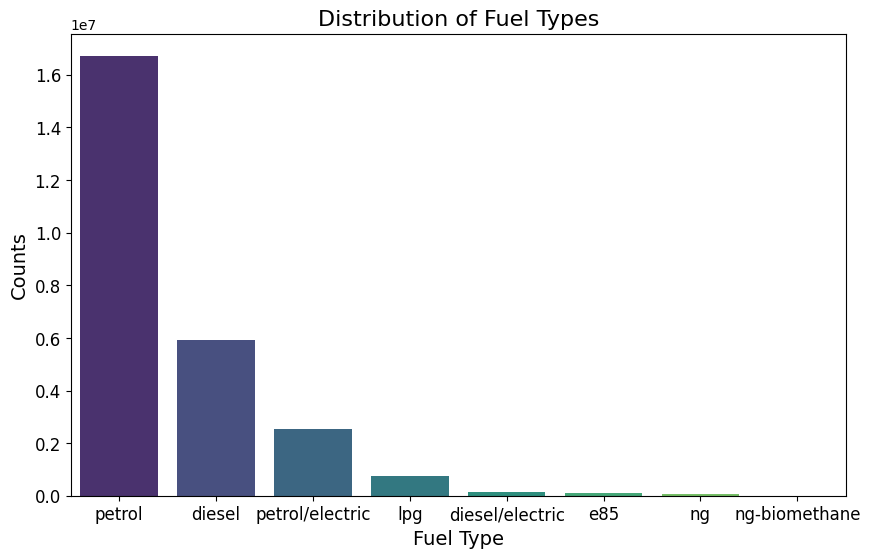

In [ ]:
#A first plot should give important insight into the distribution of fuel types, our target variable.
sns.countplot(data=df, x='fuel_type')
plt.title('Distribution of Fuel Types')

fuel_type_counts = df['fuel_type'].value_counts().reset_index()
fuel_type_counts.columns = ['Fuel Type', 'Counts']

plt.figure(figsize=(10, 6))
sns.barplot(x='Fuel Type', y='Counts', data=fuel_type_counts, palette='viridis')
plt.title('Distribution of Fuel Types', fontsize=16)
plt.xlabel('Fuel Type', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#As seen below, we can see that the classic fossil fuels are very prevalent in the data, and more modern or gas-based fuels are in the vast minority. This could influence some decisions later down the line.

In [ ]:
#Here we split up into target and data, with fuel_type and all preprocessing steps done on the data, we are ready to go.
target = df['fuel_type']
data = df.drop('fuel_type', axis=1)

numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
data_numeric = data[numeric_columns]
data = data_numeric

In [ ]:
#Standard procedure for splitting the train and test sets, and using a StandardScaler is good practise when working on numerical data
scaler = StandardScaler()

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.20, random_state=42)
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

In [ ]:
#A Decision Tree classifier should give good insight and the possibility for a tree graph.
#Besides the main Regression project, this Classification sub-project should give mainly insights into the dataset and thus focus more on Interpretability than the best possible accuracy - although of course good accuracy, and improving accuracy, still was the aim.
#Getting the Decision Tree to work was actually one of the last things I did, but I placed it here at the top of the file, so I could just use "standard", unencoded data from a fresh train_test_split
#Later models like XGBoost and Keras would require encoding, so I placed them below in the file.

clf = DecisionTreeClassifier(random_state=42)
clf.fit(data_train_scaled, target_train)

predictions = clf.predict(data_test_scaled)
accuracy = accuracy_score(target_test, predictions)
joblib.dump(clf, "clf_decisiontree")
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [ ]:
#This is done to later retrieve the names of the feature and target names, when they might have been encoded for specific model functionality requirements.
class_names = target.unique().astype(str)
print(class_names)
feature_names = data.columns
print(feature_names)

['diesel' 'petrol' 'petrol/electric' 'ng' 'lpg' 'ng-biomethane' 'e85'
 'diesel/electric']
Index(['mass_vehicle', 'engine_capacity', 'engine_power', 'fuel_consumption'], dtype='object')


In [ ]:
#Graphviz is used for visualizing a tree graph
#Due to an issue with my computer, I had to always run this PATH setting again after each model training to be able to use Graphviz and not generate errors.
graphviz_path = r'C:\Program Files\Graphviz\bin'
os.environ["PATH"] += os.pathsep + graphviz_path

#The image is output as a file in higher resolution, which seemed not realisable in the notebook directly. It was unreadable before.
#It can be found under: reports\figures\high_res_decision_tree_medium_unscaled.png
#The depth is very limited, because an unlimited amount of depth results in a file that is too large and detailed to be opened by my machine.
plt.figure(figsize=(20,10), dpi=1000)
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, max_depth=4)
plt.savefig('high_res_decision_tree_medium_unscaled.png')
plt.close()

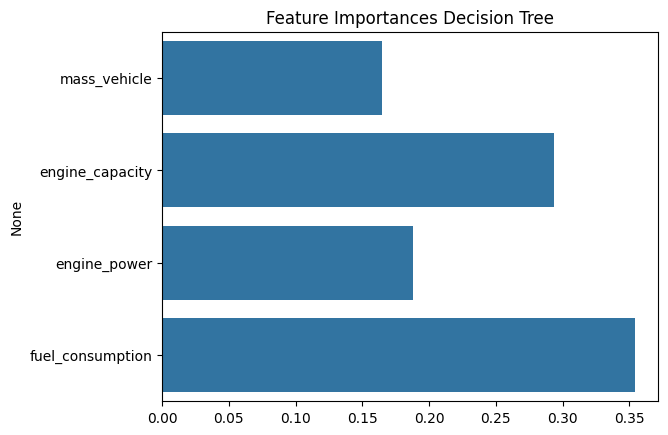

In [ ]:
feature_importances = clf.feature_importances_
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importances Decision Tree')
plt.show()
#this depicts the feature importance of the decision tree run.
#the more important features, like fuel_consumption and engine_capacitiy also appear very early and more often in the decision tree, as is supposed to be expected.

In [ ]:
#This code is mainly for documentational purposes, as it was also mentioned in the report.
#I used Dimension Reduction before we reduced the dataset as a team as a whole and runtime was not as much of an issue anymore.
#PCA was used by me to shorten extensive runtimes with XGBoost
pca = PCA(n_components=0.85)
data_train_pca = pca.fit_transform(data_train_scaled)
data_test_pca = pca.fit_transform(data_test_scaled)

In [ ]:
#Labelencoder is required for XGBoost to work, that's why I use it here.
encoder = LabelEncoder()

target_test = encoder.fit_transform(target_test)
target_train = encoder.fit_transform(target_train)

In [ ]:
#XGBoost was the first model I used after Random Tree proved too long in computational time.
#The idea was that it was able to handle larger datasets (which for ours certainly was the case) but also was tree-based, thus, providing good interpretability results.
#After reducing the dataset as a team decision, Random Tree might even have been an option again, but at that point, I had already focused on XGBoost.
model = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    enable_categorical=True,
    eval_metric='mlogloss',
    use_label_encoder=False
)
model.fit(data_train_scaled, target_train)
predictions = model.predict(data_test_scaled)

accuracy = accuracy_score(target_test, predictions)
joblib.dump(clf, "clf_xgboost")

print(f"Accuracy: {accuracy:.2f}")


C:\Users\T\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [11:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.99


<Figure size 4000x4000 with 0 Axes>

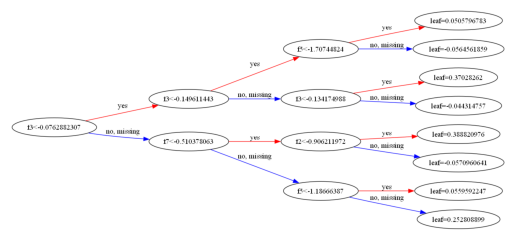

In [ ]:
#This is an artifact from XGBoost to let you see why I switched models - this tree graph is encoded, due to XGBoost's requirements, and does not give much insight.

Decoded Predictions: ['diesel' 'petrol' 'petrol' ... 'petrol' 'petrol' 'petrol']
Decoded Predictions: ['diesel' 'petrol' 'petrol' ... 'petrol' 'petrol' 'petrol']


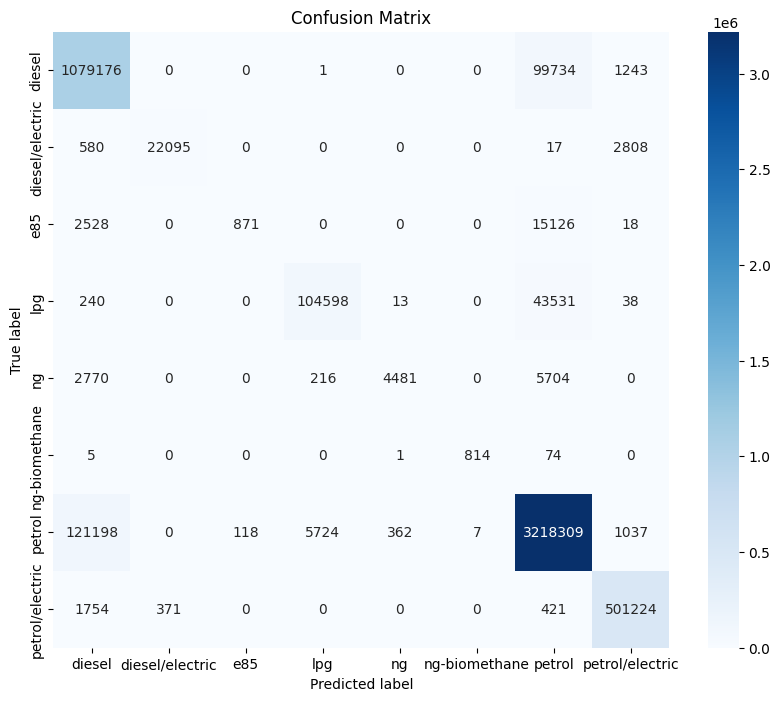

In [ ]:
#Here, the labels are decoded from XGBoost for use in a proper displayable and readable plot.
predictions_labels = encoder.inverse_transform(predictions)
target_test_decoded = encoder.inverse_transform(target_test)
print("Decoded Predictions:", predictions_labels)
print("Decoded Predictions:", target_test_decoded)

class_names = encoder.classes_

mat = confusion_matrix(target_test_decoded, predictions_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
#Though we have a high overall accuracy, this is mainly due to petrol and diesel, which are vastly overrepresented, and the model (logically) overfitting towards them.
#There is substantial variance in accuracy across the other fuels, particularly the lower accuracy for E85 and NG-Biomethane, with LPG also having only moderate accuracy.
#A remedy for that would be SMOTE: It could help create new examples in the minority classes (like E85 and NG-Biomethane) to balance the distribution, so the model could perform well for all fuel types and not overfit to the majority classes.

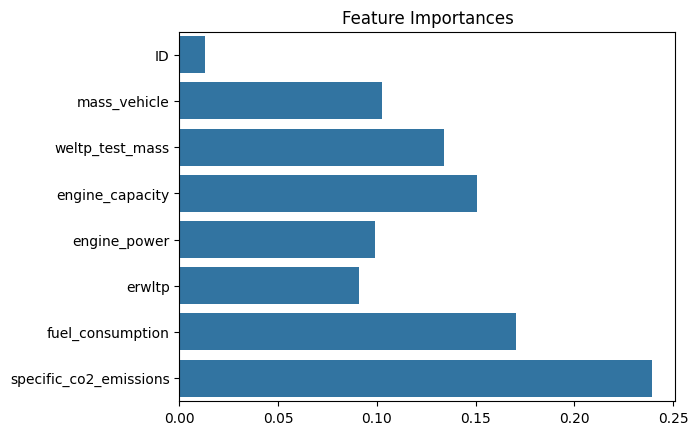

In [ ]:
#this is an older version of the feature importance graph from above.
#it still used the first, larger, set of explanatory variables.
#interestingly,  the weltp_test_mass variable scores higher in importance than its mass_vehicle counterpart.
#this could call into question our team decision to cut weltp_test_mass from our dataset instead of mass_vehicle, and retaining the other.
#still, this would require more extensive testing with adding/removing variables from the dataset. I did not have the time available to do that.
feature_importances = model.feature_importances_
feature_names = feature_names

sns.barplot(x=feature_importances, y=feature_names)

plt.title('Feature Importances')
plt.show()

In [ ]:
#Harkening back to the first Confusion Matrix, here I am employing SMOTE to remedy the issues observed there.
smote = SMOTE(k_neighbors = 3, random_state=42)
data_train_smoted, target_train_smoted = smote.fit_resample(data_train_scaled, target_train)

In [ ]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    enable_categorical=True,
    eval_metric='mlogloss',
    use_label_encoder=False
)

model.fit(data_train_smoted, target_train_smoted)

predictions = model.predict(data_test_scaled)
accuracy = accuracy_score(target_test, predictions)

joblib.dump(xgb, "clf_xgboost_smoted")

print(f"Accuracy: {accuracy:.2f}")


C:\Users\T\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [10:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.93


Decoded Predictions: ['diesel' 'petrol' 'petrol' ... 'petrol' 'petrol' 'petrol']
Decoded Predictions: ['diesel' 'petrol' 'petrol' ... 'petrol' 'petrol' 'petrol']


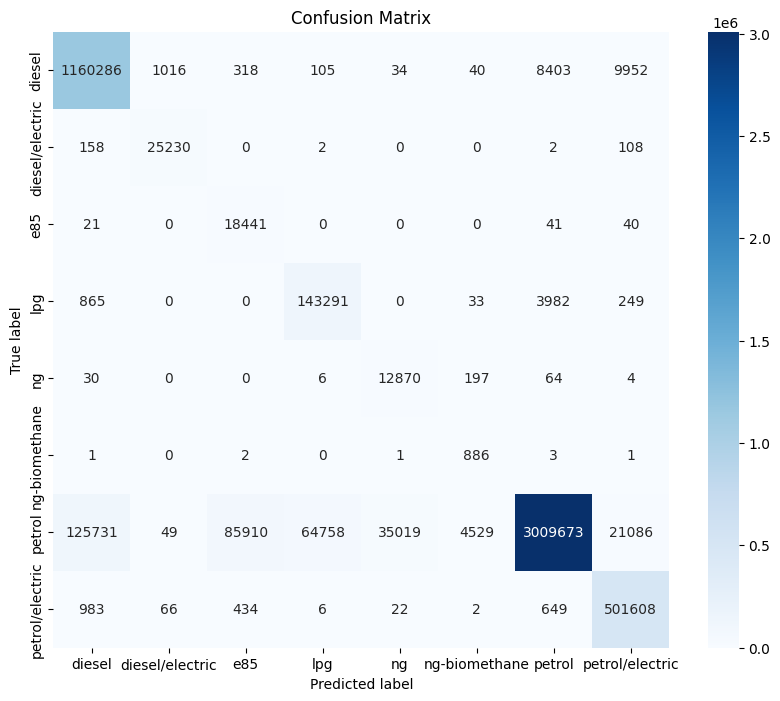

In [ ]:
#Now it was time for another confusion matrix, to see how SMOTE had affected the prediction capabilities.
predictions_labels = encoder.inverse_transform(predictions)
target_test_decoded = encoder.inverse_transform(target_test)

print("Decoded Predictions:", predictions_labels)
print("Decoded Predictions:", target_test_decoded)

class_names = encoder.classes_

mat = confusion_matrix(target_test_decoded, predictions_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
#As we can see, accuracy improved a lot, especially for the beforehand underrepresented E85, LPG and NG-Biomethane, which now were better represented in the dataset. Definitely a successful employment of SMOTE.
#Petrol, the most prevalent datatype, took a small hit in accuracy. But for a universally useful classification model that doesn’t overfit to Petrol (and classifies that almost always correctly, but the minority classes wrongly), this was definitely a good result.

In [ ]:
#This is a very rudimentary implementation of a deep learning model, with a very limited epoch amount
#Since I had skipped exams to keep up with the project, which I spoke about beforehand with my Program Manager Arsilejda, I had limited knowledge in Keras and Deep Learning.
#We only had four days (counting the weekend) to deliver the first version of our modeling report and implement Deep Learning, so this is why this is limited.
#Categorical crossentropy is used because we have a deep learning problem with Classification as the base, using categorical target variables that can not be reduced to a binary Classification problem.

target_train = to_categorical(target_train)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(target_train.shape[1], activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

C:\Users\T\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    data_train_scaled,
    target_train,
    epochs=1,
    validation_split=0.2,
    batch_size=32
)

523721/523721 ━━━━━━━━━━━━━━━━━━━━ 716s 1ms/step - accuracy: 0.9874 - loss: 0.0399 - val_accuracy: 0.9892 - val_loss: 0.0335


In [ ]:
target_test_encoded = to_categorical(target_test, num_classes=8)
test_loss, test_accuracy = model.evaluate(data_test_scaled, target_test_encoded)
model.save("clf_keras")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

#The end result, judging at least by accuracy, is keeping up with the Classification models.
#With more time, it would be interesting to explore more about using Optimization and also Interpretability Techniques on this Deep Learning approach to dive in even further into the topic.

163663/163663 ━━━━━━━━━━━━━━━━━━━━ 153s 937us/step - accuracy: 0.9893 - loss: 0.0333
Test Loss: 0.034, Test Accuracy: 0.989
